# Head and Tail Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scienceplots

Calculate Intensity and Identify Tune Frequency

In [8]:
# Gaussian function for fit
def gaussian(x, amplitude, mean, std_dev, c):
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2)) + c

def linear_func(x, a, b):
    return a * x + b

def FreqIntensity(time,min_turn,max_turn,skip=[],debug=False):

    booster_turns = [2,4,6,8,10,11,14]
    Max_Frequency = np.zeros((len(booster_turns),5))
    Intensity = np.zeros((len(booster_turns),5))
    
    Intensity_Avg = np.zeros(len(booster_turns))
    Intensity_Std = np.zeros(len(booster_turns))
    Max_Frequency_Avg = np.zeros(len(booster_turns))
    Max_Frequency_Std = np.zeros(len(booster_turns))

    for t, turns in enumerate(booster_turns):
        for repeat in range(5):
            if (str(turns)+"."+str(repeat)) in skip:
                continue
            #print("Booster Turns: ",turns)
    
            # Calculate average intensity in the 0.04s around 0.57s
            try:
                intensity_data = np.loadtxt(r'C:\\Users\bengl\Documents\summerIntern\data_studies\\' + str(turns) + r'turns'+str(repeat)+'_beam')
                AB = np.load(r'C:\\Users\bengl\Documents\summerIntern\data_studies\\coherent_tune_shift\\'+str(turns)+r'turns00' +str(repeat)+'.npy',allow_pickle=True)
            except:
                continue
            mask = (intensity_data[0:,0] > 0.55) & (intensity_data[0:,0] < 0.59)
            Averaged_Intensity = np.mean(intensity_data[0:,1][mask])
        
    
            # Calculate the position
            time_along_bunch = np.linspace(-0.75e-7,0.75e-7,7500)
            AmB = AB[0]
            ApB = -1*AB[1]+50
            position = AmB/ApB
    
            """
            fig,ax = plt.subplots(3,1,dpi=100,sharex=True, figsize=(4,4))

            ax[0].plot(time_along_bunch,AmB[4000])
            ax[1].plot(time_along_bunch,ApB[4000])
            ax[2].plot(time_along_bunch,position[4000])
            ax[0].set_xlabel('Time (s)')
            ax[0].set_ylabel('A-B (Volt)')
            ax[1].set_ylabel('A+B (Volt)')
            ax[2].set_ylabel('A-B/A+B (Distance)')
            plt.show()
            """
    
            # Find position at a given time for each turn
            time_index = np.argmin(np.abs(time_along_bunch - time))
            """
            plt.plot(position[:, time_index])
            plt.xlabel('Turn')
            plt.ylabel('Position')
            plt.show()
            """
    
            # Fourier transform the position data
            position_at_time = position[:, time_index]
            position_slice = position_at_time[min_turn:max_turn]
            fourier = np.fft.fft(position_slice)
            freq = np.fft.fftfreq(len(position_slice))
    
            # Look in certain range
            mask = (freq>0.44) & (freq<0.48)
            freq_range = freq[mask]
            fourier_range = np.abs(fourier[mask])

            # Fit a gaussian to the peak
            p0 = [1.4, 0.460, 0.005, 0.07]  # Initial guess for the parameters
            lower_bounds = [0, 0.458, 0, 0.01]
            upper_bounds = [2, 0.465, 0.01, 0.1]
            bounds = (lower_bounds, upper_bounds)
            fit_params, _ = curve_fit(gaussian, freq_range, fourier_range, p0=p0, bounds=bounds)
            amplitude_fit, mean_fit, std_dev_fit, c_fit = fit_params
            fitted_curve = gaussian(freq_range, amplitude_fit, mean_fit, std_dev_fit, c_fit)

            # Plotting
            if debug==True:
                plt.plot(freq_range, fourier_range, label='Fourier Transformed Data')
                plt.plot(freq_range, fitted_curve, label='Fitted Curve')
                plt.title('Fourier Transform of Position at time = ' + str(time) + 's with ' + str(turns) + ' Booster Turns')
                plt.xlabel('Frequency')
                plt.ylabel('Amplitude')
                plt.legend()
                plt.show()
            
            
            # In case only one data point
            Max_Frequency_Avg[t] = mean_fit
            #Max_Frequency_Std[t] = std_dev_fit
            Max_Frequency_Std[t] = 0.002/2
            
            
            Max_Frequency[t][repeat] = mean_fit
            Intensity[t][repeat] = Averaged_Intensity
    
    # Remove rows if no data for that booster turn        
    # Create a boolean mask indicating which rows contain all zeros
    mask = np.any(Intensity != 0, axis=1)

    # Use the mask to select the rows without all zeros
    Intensity = Intensity[mask]
    Max_Frequency = Max_Frequency[mask]
    Max_Frequency_Avg = Max_Frequency_Avg[mask]
    Max_Frequency_Std = Max_Frequency_Std[mask]
    Intensity_Avg = Intensity_Avg[mask]
    Intensity_Std = Intensity_Std[mask]

    for i in range(Intensity.shape[0]):
        I_list = Intensity[i,:][Intensity[i,:]>0]
        if len(I_list) == 1:
            continue
        else:
            Intensity_Std[i] = np.std(I_list)
            Intensity_Avg[i] = np.mean(I_list)

            list = Max_Frequency[i,:][Max_Frequency[i,:]>0]
            Max_Frequency_Avg[i] = np.mean(list)
            Max_Frequency_Std[i] = np.std(list)
    
    # Set the STD of the Intensity to the maximum of the others (if only one data point)
    for i in range(Intensity.shape[0]):
        I_list = Intensity[i,:][Intensity[i,:]>0]
        if len(I_list) == 1:
            Intensity_Std[i]=max(Intensity_Std)
            Intensity_Avg[i]=I_list[0]
          
    
    params, _ = curve_fit(
    linear_func, Intensity_Avg, Max_Frequency_Avg, sigma=Max_Frequency_Std, absolute_sigma=True
    )
    # Extract the fitted parameters
    a, b = params
    # Plot
    fig, ax = plt.subplots(figsize=(6,4), dpi=800)
    plt.style.use('science')
    plt.xlabel(r'E $\times 10^{12}$ (ppb)')
    plt.ylabel('Tune Frequency')
    plt.title('Tune Frequency vs Intensity')
    plt.errorbar(Intensity_Avg,Max_Frequency_Avg,xerr=Intensity_Std,yerr=Max_Frequency_Std, fmt='x', markersize=3, markeredgewidth=0.5, ecolor='black', capsize=2, elinewidth=0.5, capthick=0.5)
    plt.plot(Intensity_Avg,a*np.array(Intensity_Avg)+b, label='Linear Fit', color='red', linewidth=0.5)
    plt.show()


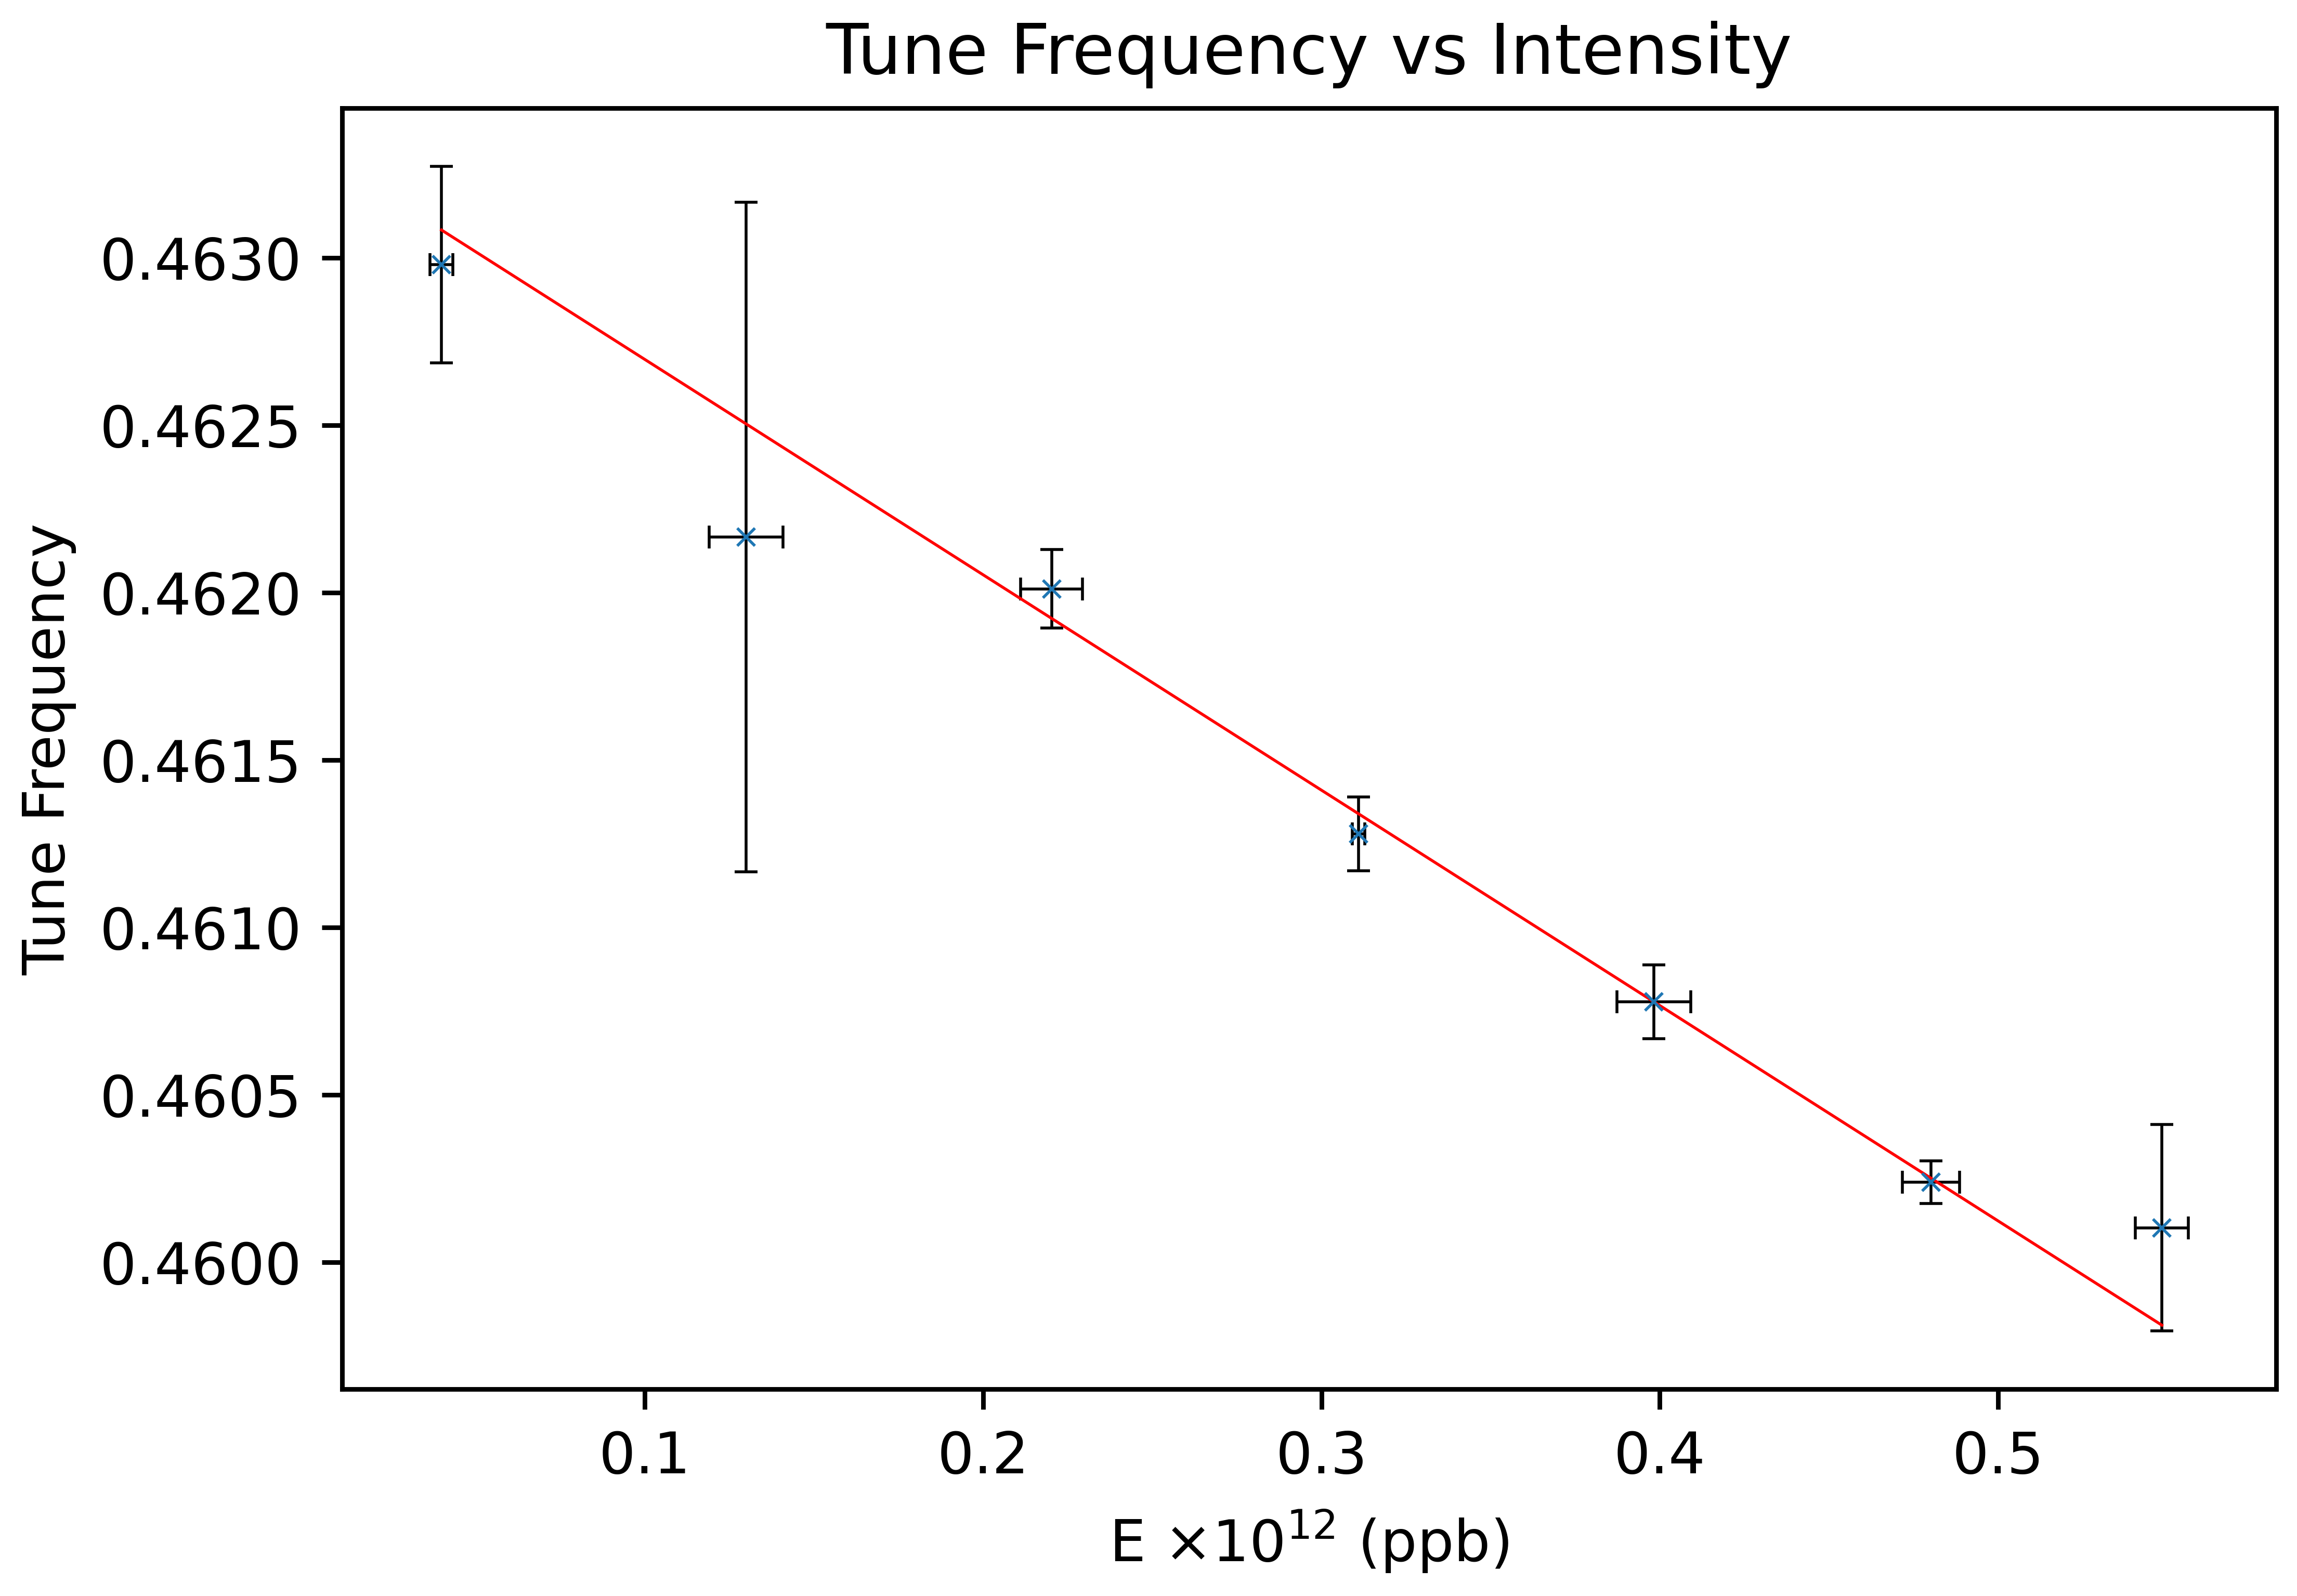

In [9]:
FreqIntensity(time = 1.5e-8,min_turn = 0,max_turn = 10000)

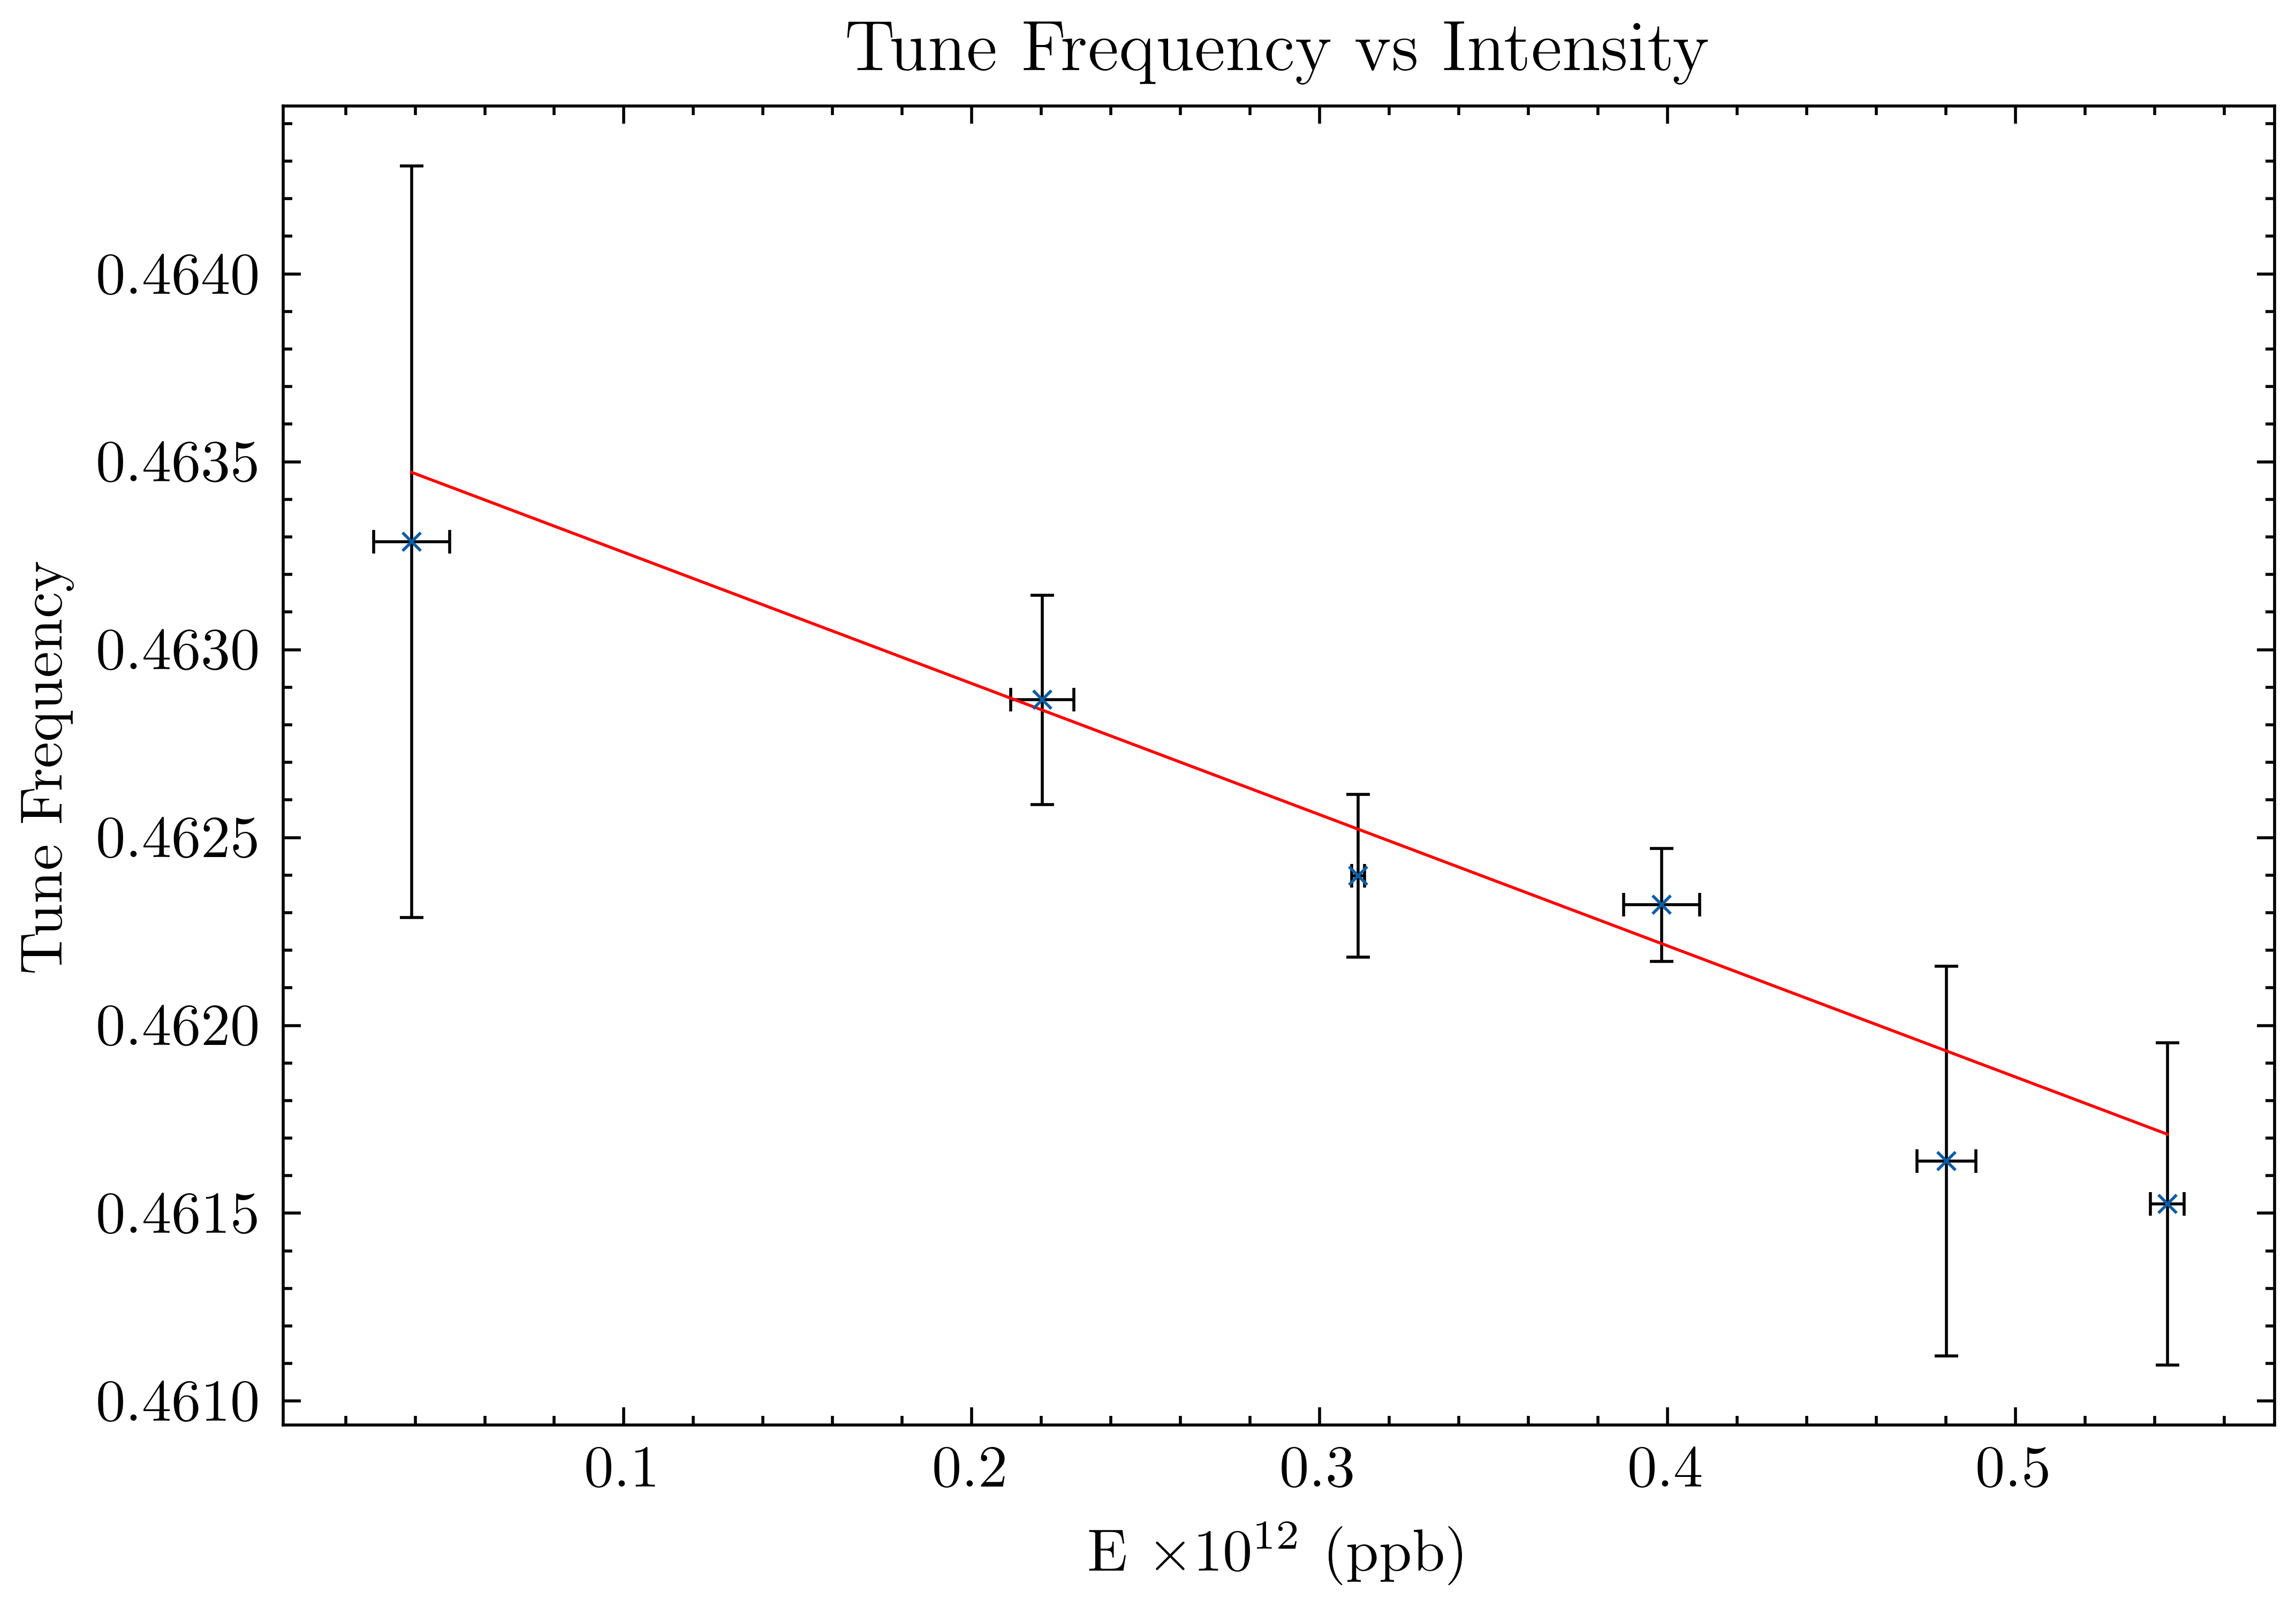

In [12]:
FreqIntensity(time = -2e-8,min_turn = 0,max_turn = 10000, skip=["2.1","2.2","4.0","14.1"])

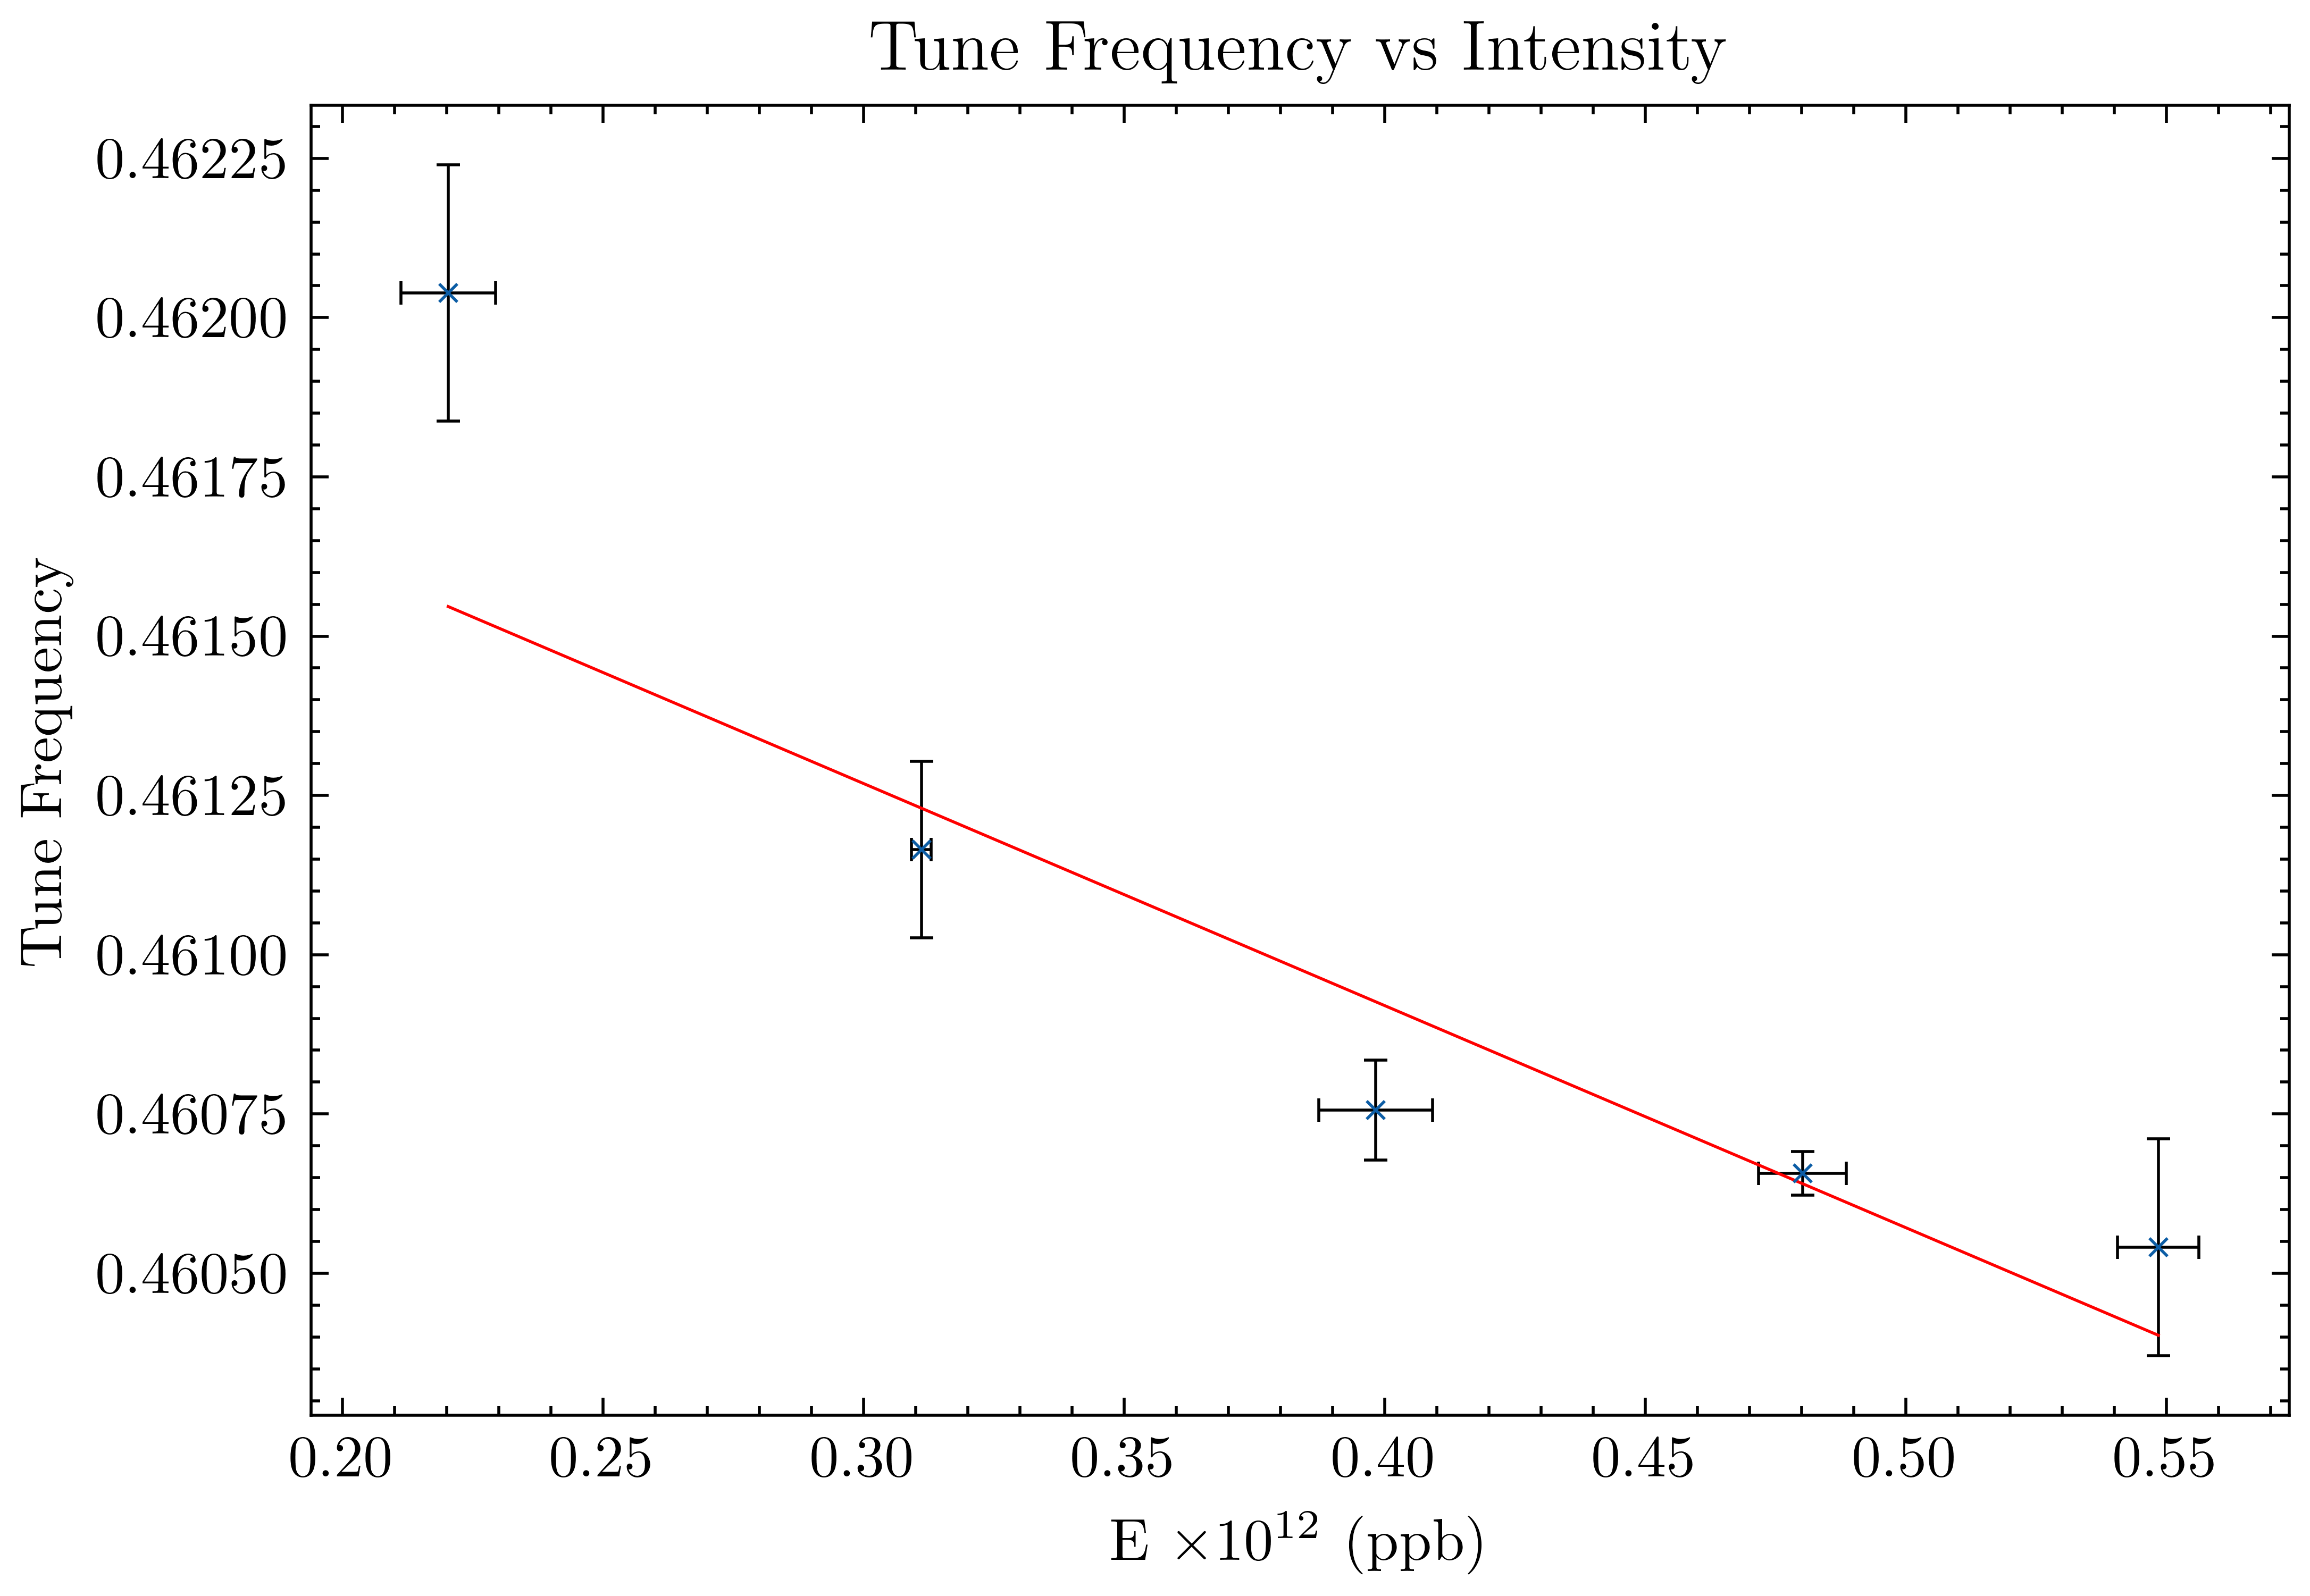

In [13]:
FreqIntensity(time = 5e-8,min_turn = 0,max_turn = 10000, skip=["2.0","2.1","2.2","4.0"])

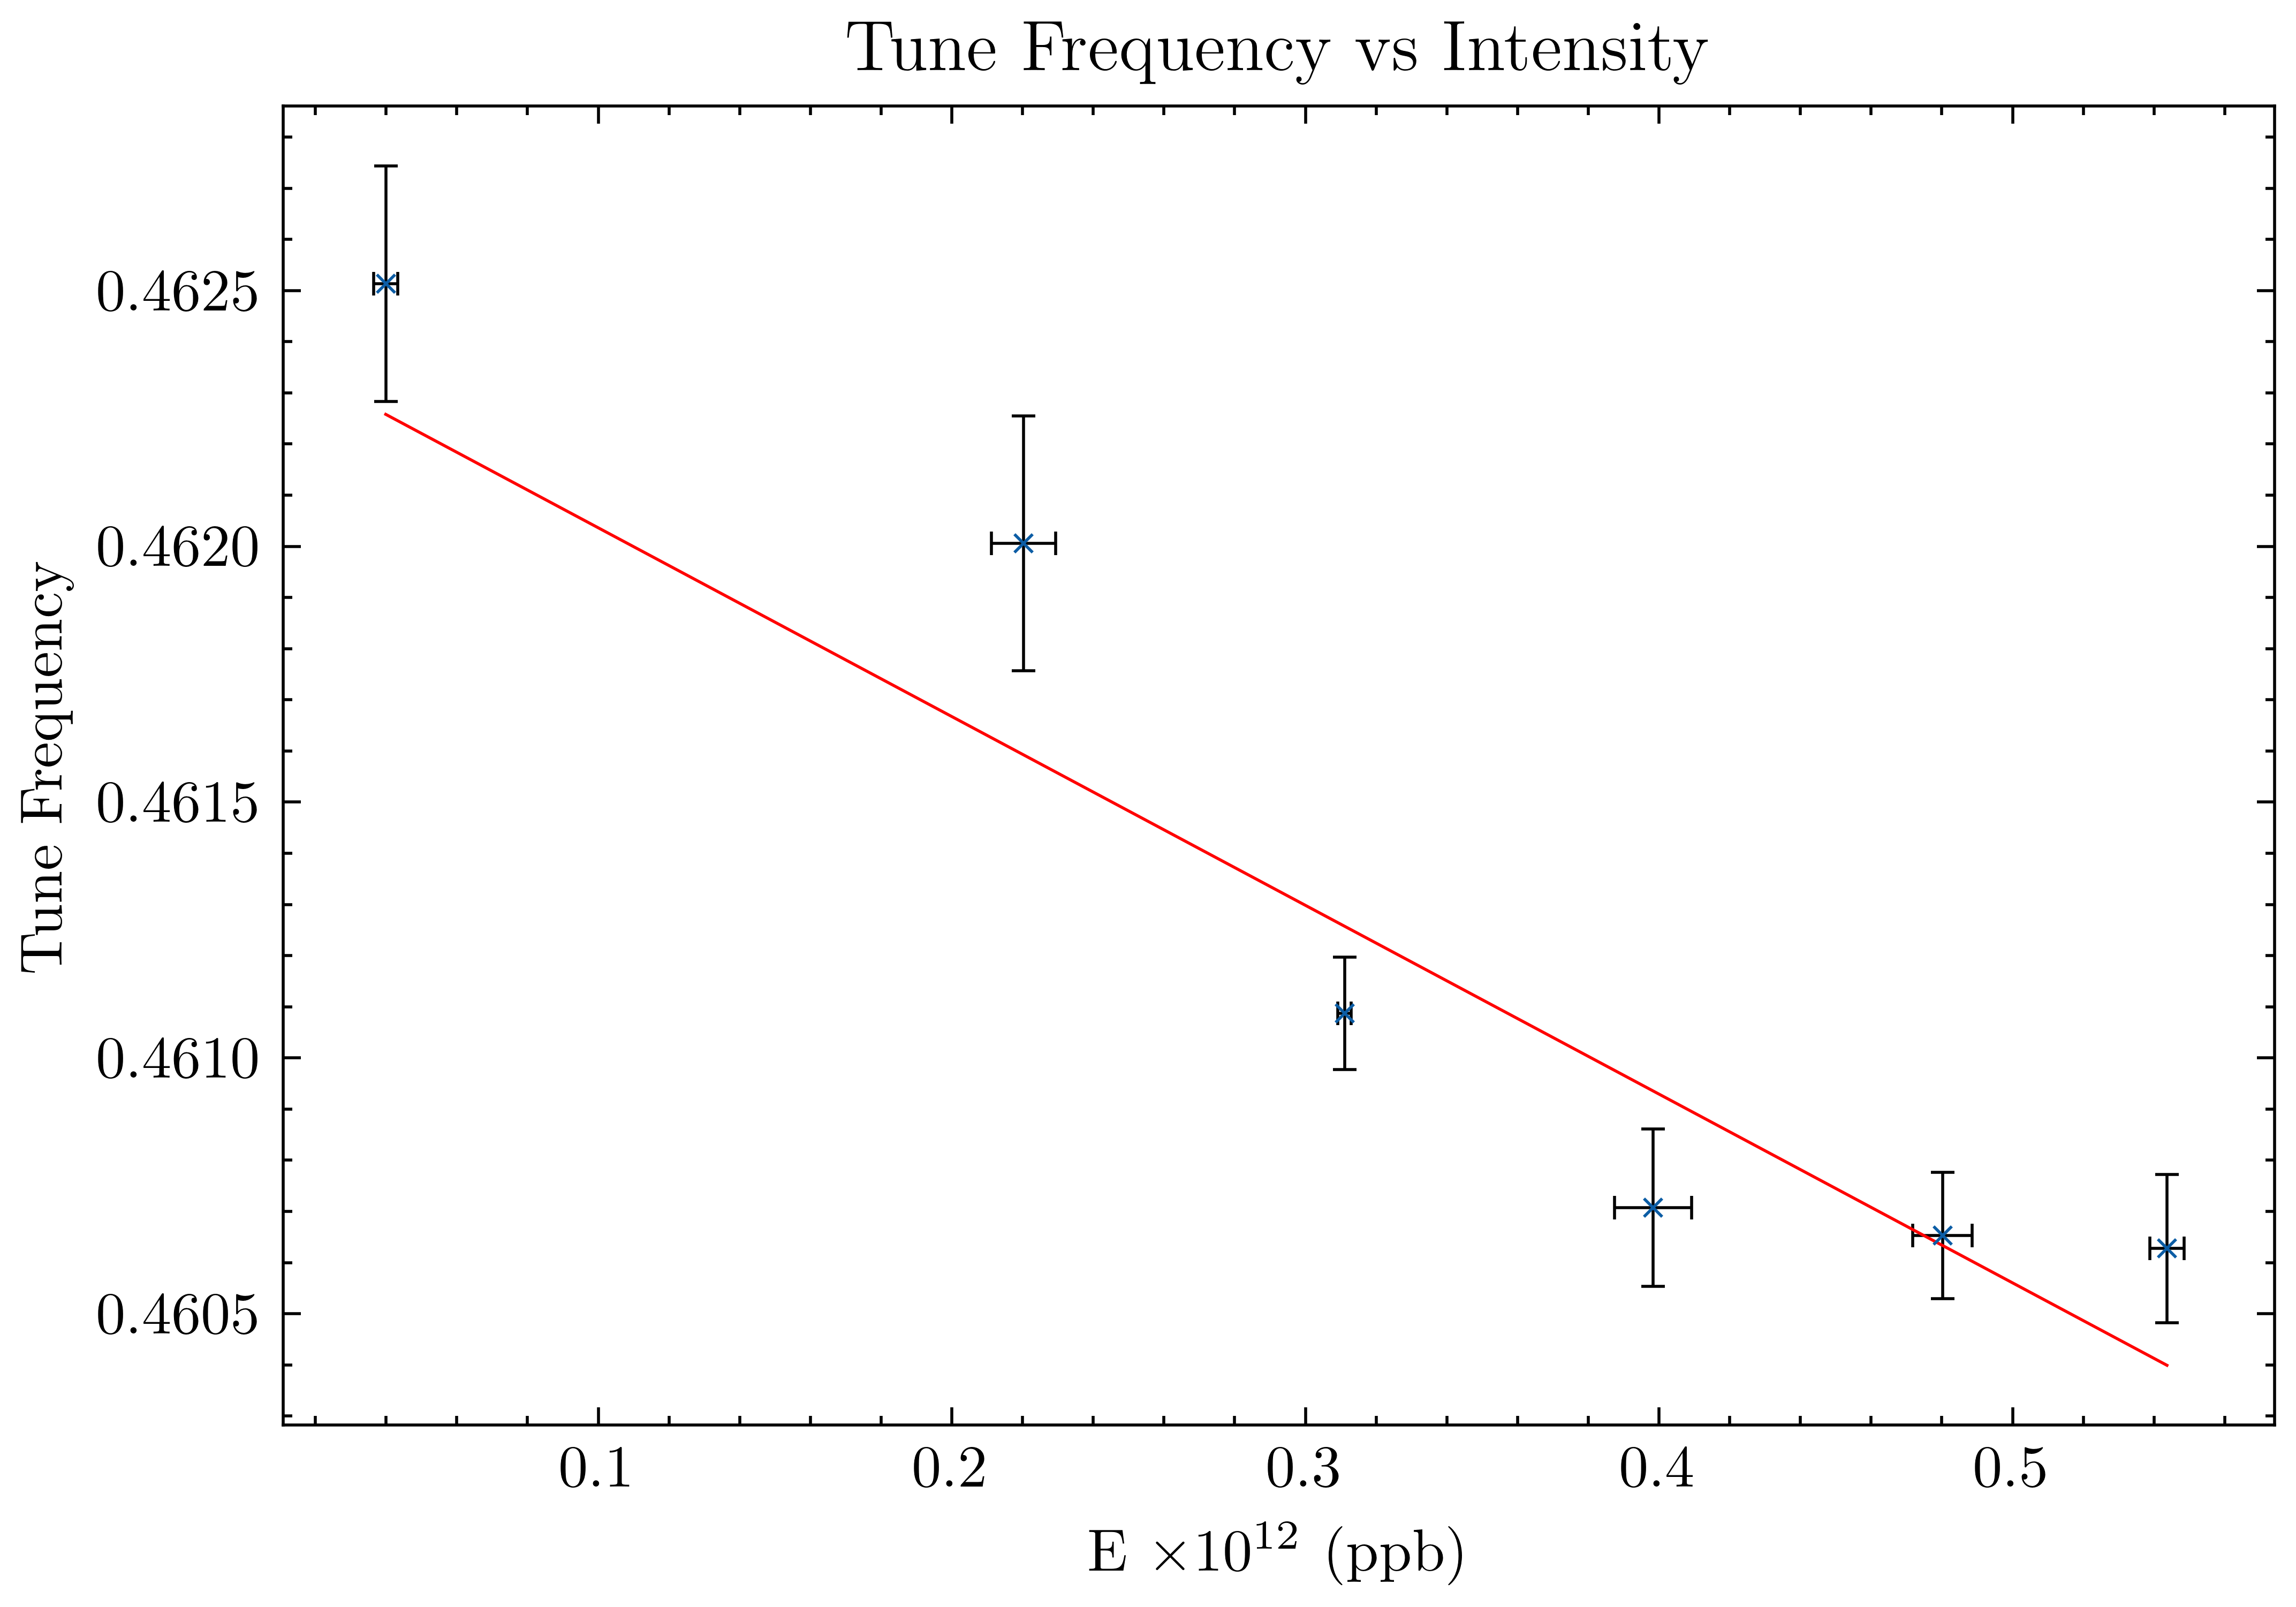

In [14]:
FreqIntensity(time = 5.5e-8,min_turn = 2000,max_turn = 4000, skip=["4.0","14.1"])

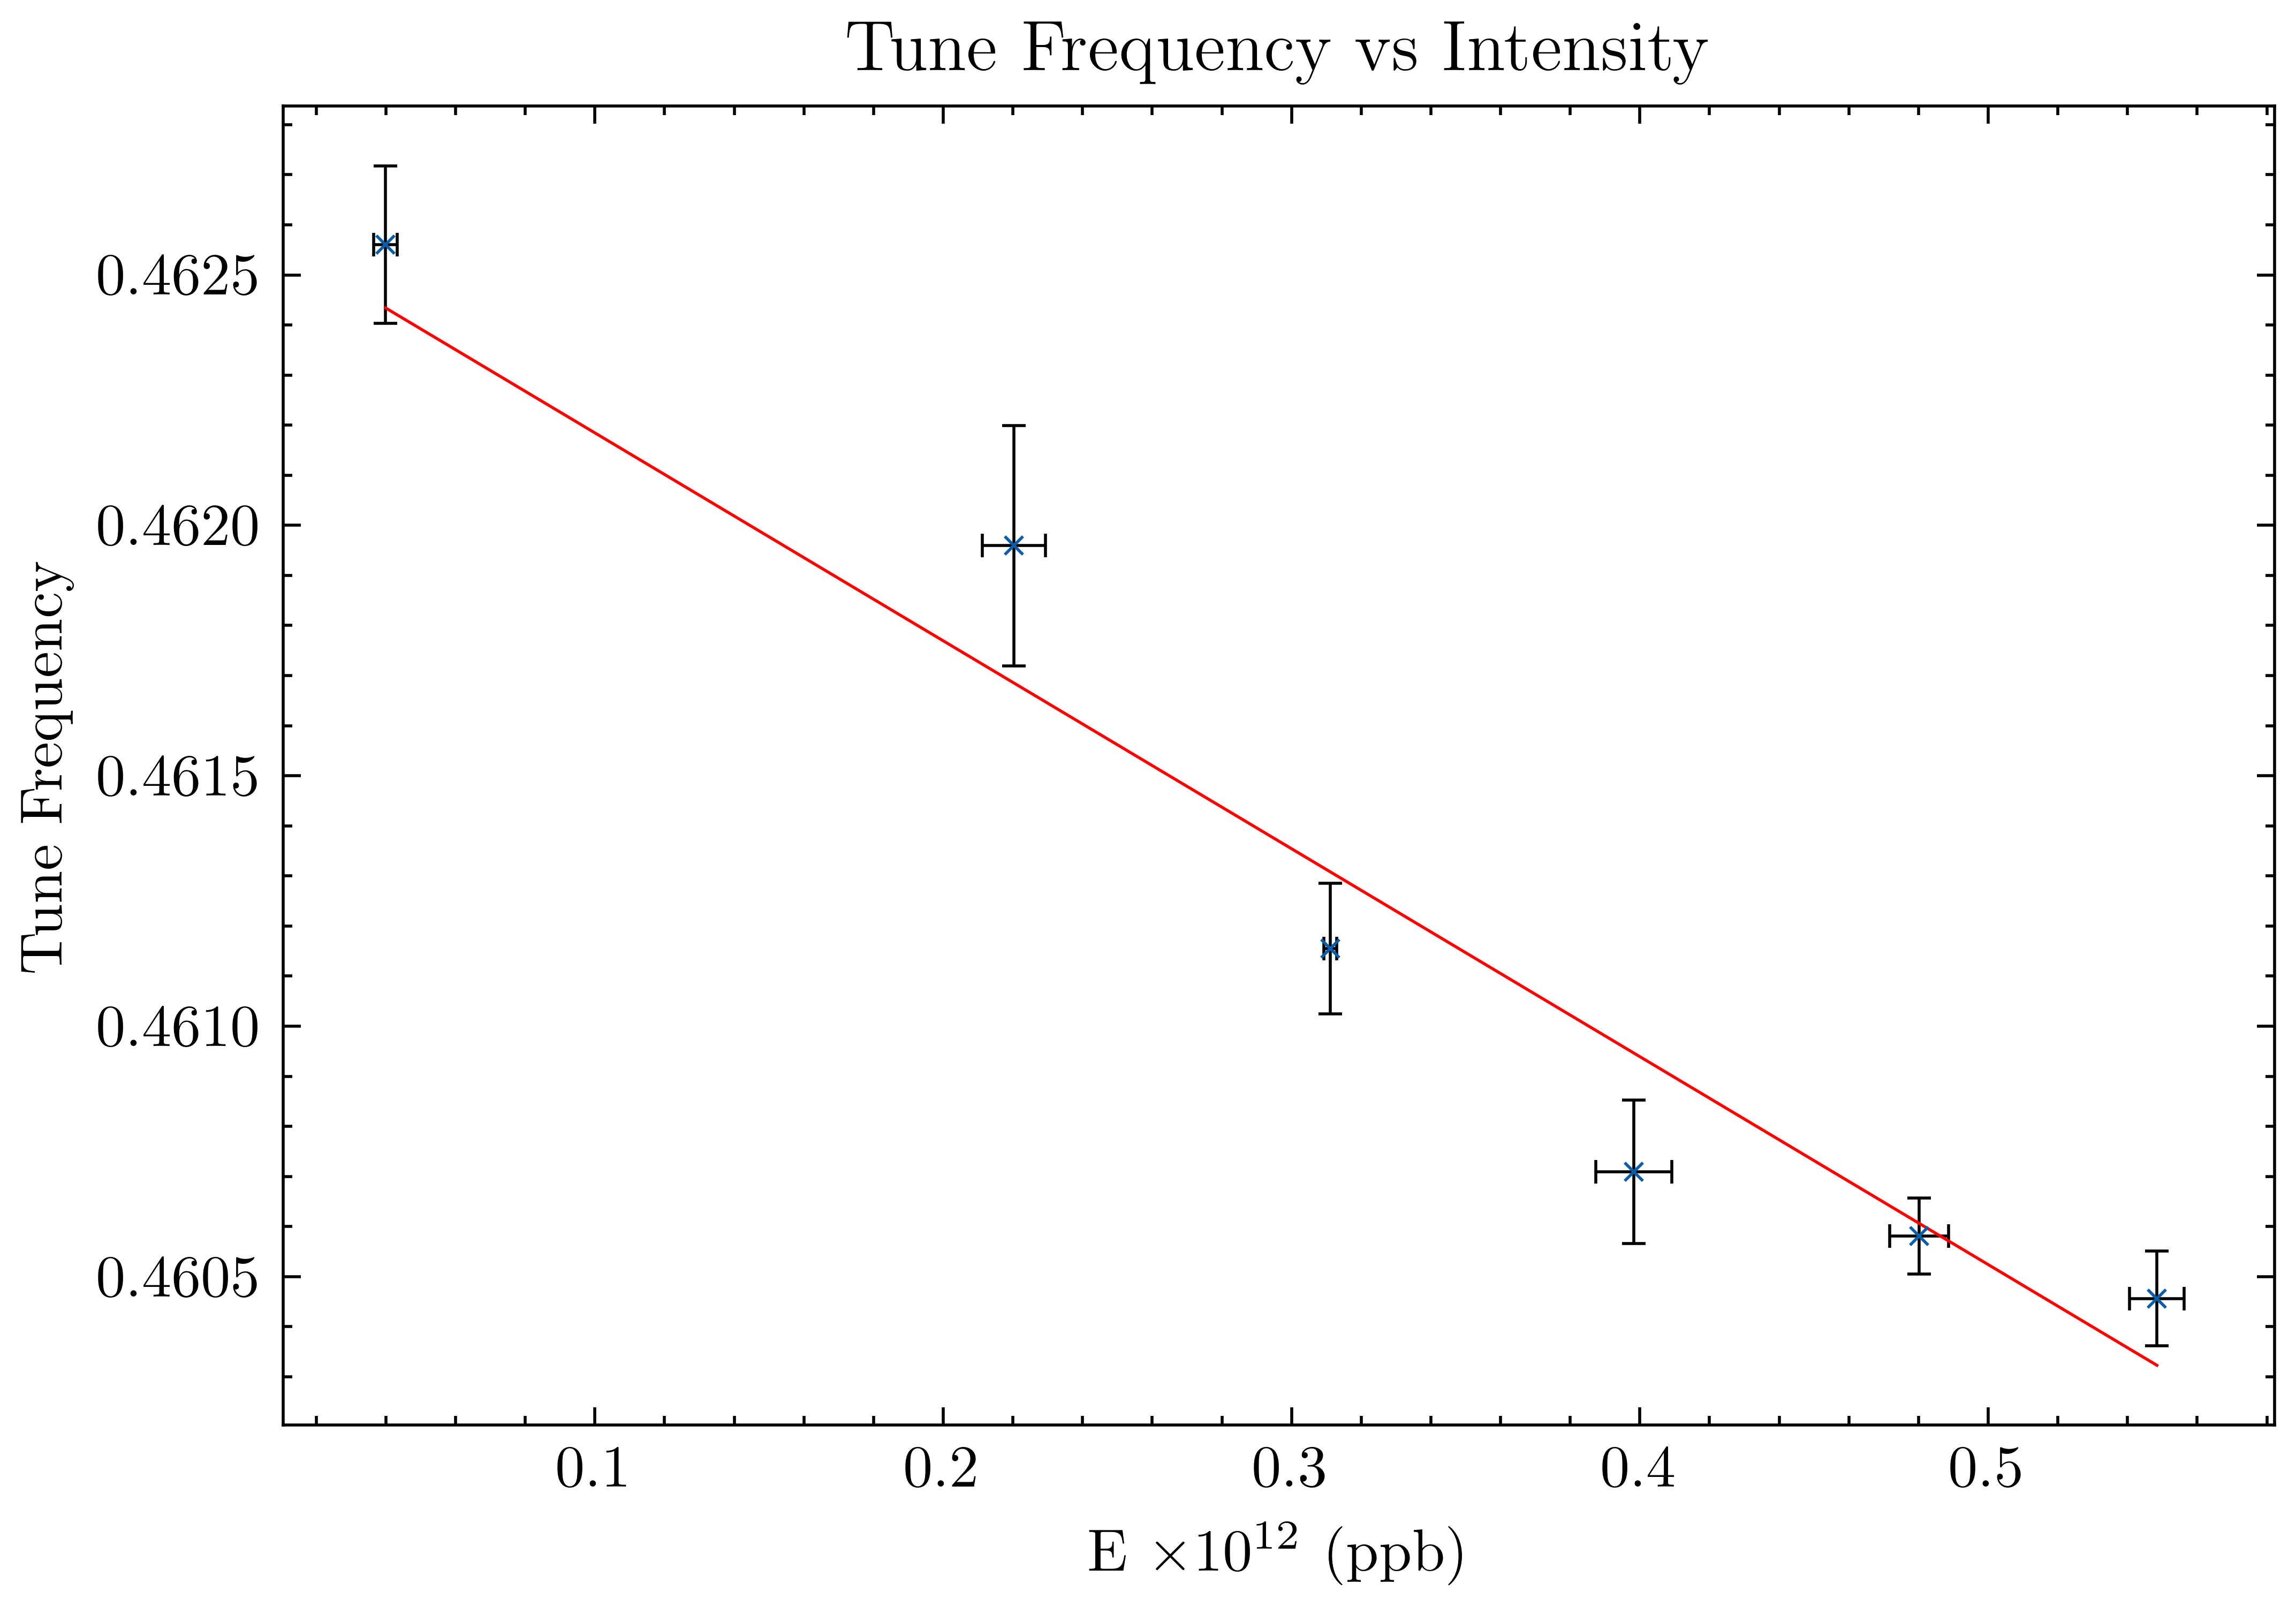

In [15]:
FreqIntensity(time = 5e-8,min_turn = 2000,max_turn = 4000, skip=["4.0"])